<a href="https://colab.research.google.com/github/byarciptap/projects/blob/main/Portfolio%20Project/Fix_of_Credit_Risk_Analysis_with_Predictions_Byar_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

---
**Objective Analysis**:
* Describes a predictive model that is able to predict an applicant's credit risk with high accuracy.
* Determine the main factors that contribute to an applicant's credit risk.
* Provide recommendations to the approval department regarding the use of this model in the credit approval process.

---

The following are details of each feature in the dataset :    
* ID: Unique identifier for each loan applicant.
* Age: Age of the loan applicant.
* Income: Income of the loan applicant.
* Home: Home ownership status (Own, Mortgage, Rent).
* Emp_Length: Employment length in years.
* Intent: Purpose of the loan (e.g., education, home improvement).
* Amount: Loan amount applied for.
* Rate: Interest rate on the loan.
* Status: Loan approval status (Fully Paid, Charged Off, Current).
* Percent_Income: Loan amount as a percentage of income.
* Default: Whether the applicant has defaulted on a loan previously (Yes, No).
* Cred_Length: Length of the applicant's credit history.

---

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report,roc_auc_score,accuracy_score,f1_score,roc_curve
!pip install ycimpute
from ycimpute.imputer import knnimput
!pip install category-encoders
from category_encoders import MEstimateEncoder, TargetEncoder
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


# Data Load and General Overview

In [ ]:
dataset = 'https://docs.google.com/spreadsheets/d/1PhhSA5OzsZAVdvfHXVoRHTUrzDP2f_YHBbwvq8Q3TY4/edit#gid=1788242673'
dataset_trf = dataset.replace('/edit#gid=','/export?format=csv&gid')
df_og = pd.read_csv(dataset_trf)
df = df_og.copy(deep=True)
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,32581.0,NaN,NaN,NaN,16290.006139,9405.479594,0.0,8145.0,16290.0,24435.0,32780.0
Age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
Income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
Home,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
Intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
Rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
Status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
Percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


In [ ]:
df.shape

(32581, 12)



---

Observe :


*   Dataset has 12 features and 32,581 samples. Status of these features is target (dependent) variable
*   Dataset has object, numeric. Also it has missing values


---



# Mutual Information

In [ ]:
X = df.copy()
X.drop('Id', axis=1, inplace=True)
y = X.pop('Status')

In [ ]:
#Temporary convert for operation of Mutual Information
for col_name in X.select_dtypes(["object"]):
    X[col_name], _ = X[col_name].factorize()

In [ ]:
#Temporary fill missing values for operation of Mutual Information
X = X.apply(lambda x:x.fillna(x.mean())).astype(int)

In [ ]:
features = X.dtypes == int

In [ ]:
def MakeMiScore (X,y,disc_features):
  mi_scores = mutual_info_classif(X,y,discrete_features=disc_features)
  mi_scores = pd.Series(mi_scores, name='MI Scores', index = X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

In [ ]:
print(MakeMiScore(X,y,features))

Income            0.187774
Rate              0.057878
Home              0.030677
Amount            0.028126
Default           0.014507
Intent            0.008076
Emp_length        0.005828
Age               0.002023
Cred_length       0.000628
Percent_income    0.000000
Name: MI Scores, dtype: float64


In [ ]:
def PlotScore(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list (scores.index)
  plt.barh(width,scores)
  plt.yticks(width,ticks)
  plt.title('Mutual Information Scores')

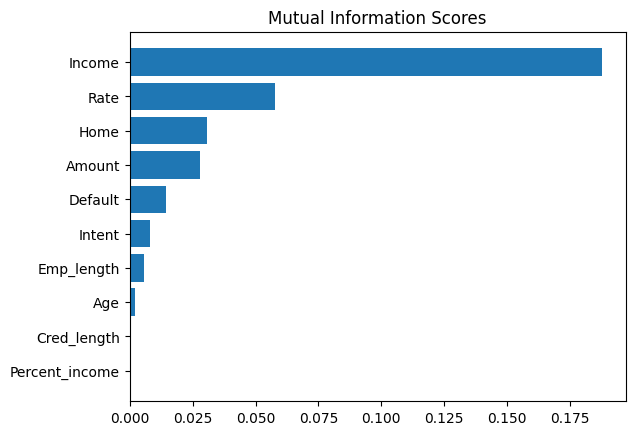

In [ ]:
PlotScore(MakeMiScore(X,y,features))

# EDA

In [ ]:
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


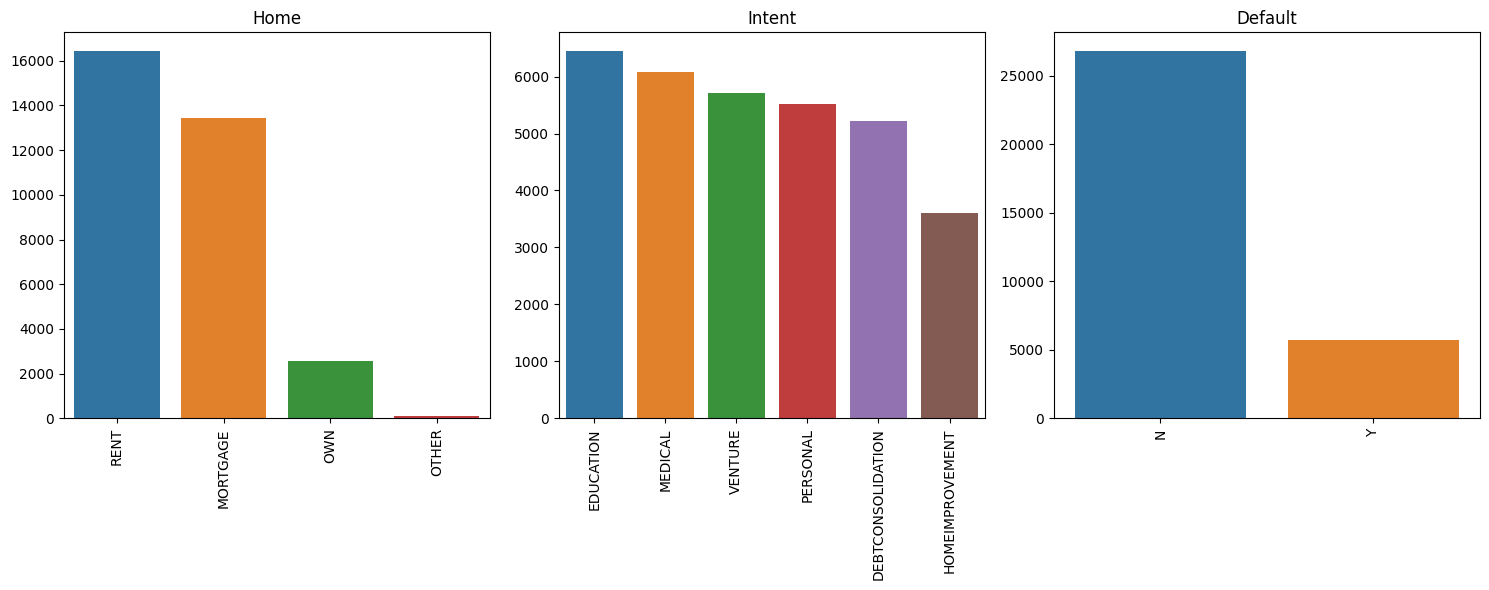

In [ ]:
# List of categorical variables
cat_vars = ['Home', 'Intent', 'Default']

# Create a figure with subplots (2 rows, 1 column)
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Loop through categorical variables
for i, var in enumerate(cat_vars):
    # Count the categories and sort them in descending order
    category_counts = df[var].value_counts().sort_values(ascending=False)

    # Create a countplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=axs[i])

    # Rotate x-axis labels for better readability
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)

    # Set plot title
    axs[i].set_title(var)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

Observe :    
* Most applicants did not default on previous loans, with loan intent almost evenly divided among education, medical, and others. Additionally, the majority of applicants do not own a home (most are renting).

In [ ]:
numerical_columns = df.select_dtypes(exclude=['object'])
numerical_columns.columns

Index(['Id', 'Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Status',
       'Percent_income', 'Cred_length'],
      dtype='object')

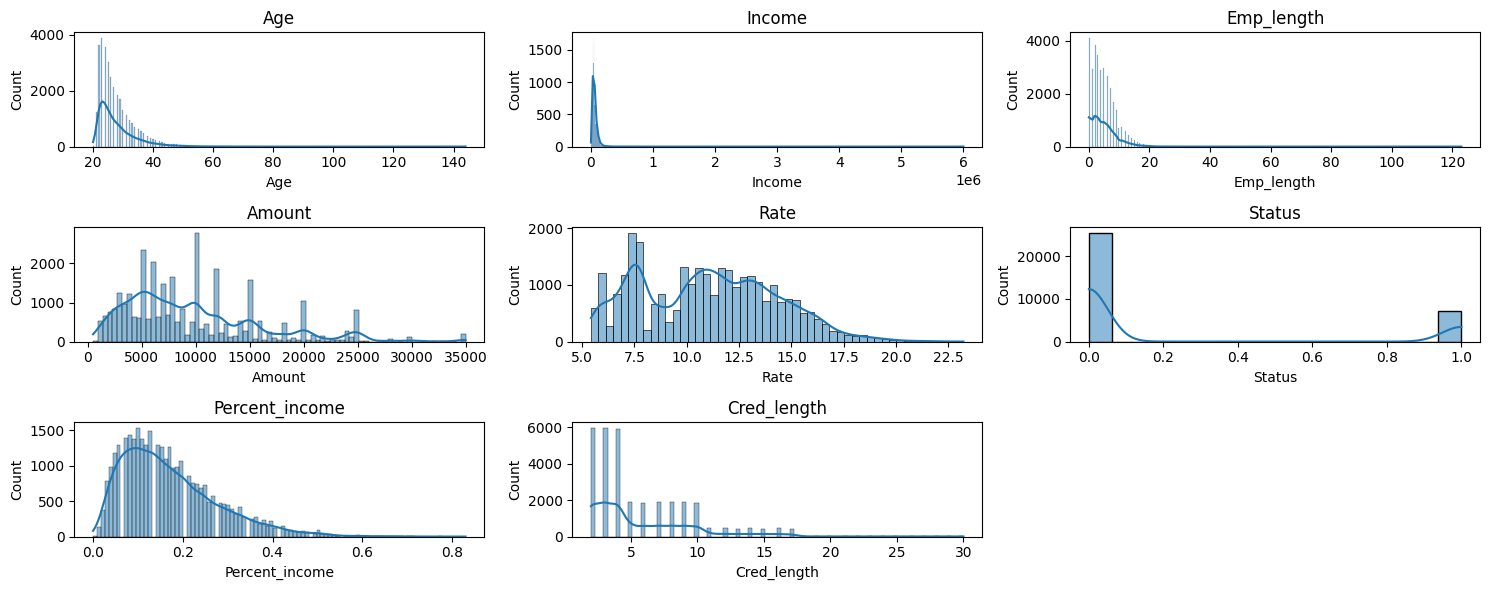

In [ ]:
# List of numerical variables
num_vars = ['Age', 'Income', 'Emp_length', 'Amount', 'Rate', 'Status',
       'Percent_income', 'Cred_length']

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 6))

# Loop through categorical variables
for i, var in enumerate(num_vars):
    # Create a boxplot for each numerical variable
    sns.histplot(df[var], ax=axs[i // 3, i % 3], kde=True) # Set kde=True for Kernel Density Estimate plot

    # Set plot title
    axs[i // 3, i % 3].set_title(var)

# Remove any empty subplots
for i in range(len(num_vars), len(axs.ravel())):
    fig.delaxes(axs.ravel()[i])
# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


<ipython-input-21-b43d6d22cd95>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_without_id.corr()


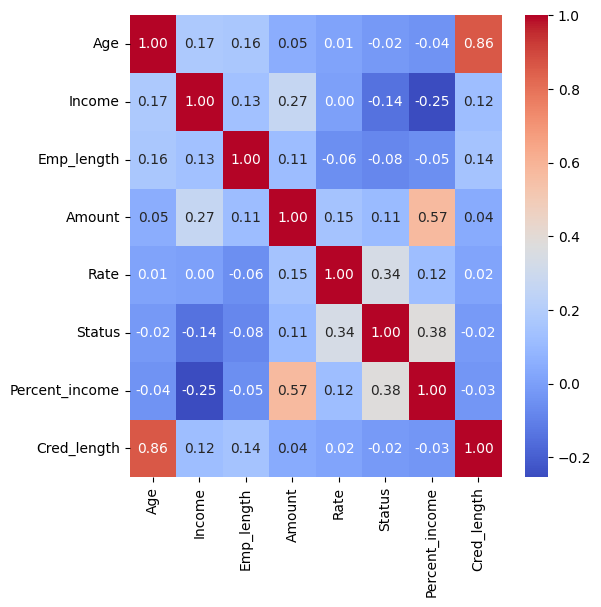

In [ ]:
# Menghapus kolom 'Id' dari DataFrame
df_without_id = df.drop('Id', axis=1)

# Menghitung matriks korelasi (default: korelasi Pearson) dari DataFrame tanpa kolom 'Id'
correlation_matrix = df_without_id.corr()

# Membuat heatmap dari matriks korelasi
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


# Menampilkan plot
plt.show()

Observe :    
* There is a fairly strong correlation between the age variable and the cred_length variable, this could be a sign of multicollinearity
* Multicollinearity can greatly affect a regression model because it can make the regression coefficients unstable and difficult to interpret.
* To overcome this multicollinear problem, it is necessary to consider using ensemble models that can handle multicollinear problems such as Random Forest, GBM, LGBM and XGB.

## Status (Target)

<Axes: >

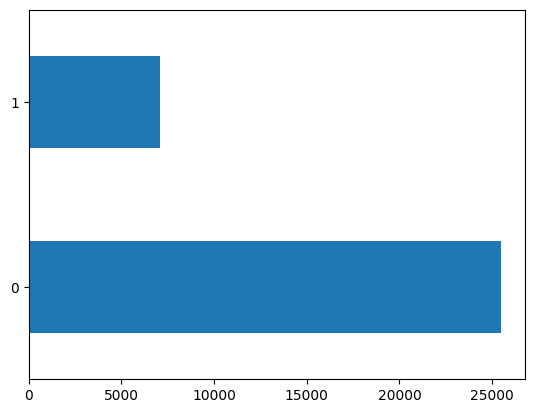

In [ ]:
df['Status'].value_counts().plot.barh()

Observe :    
* There is an imbalance in the data on the target variable, this can result in the model not being able to recognize one of the classes properly because the sample is unbalanced
* oversampling can be an option to overcome data imbalance

## Home

RENT        0.504773
MORTGAGE    0.412633
OWN         0.079310
OTHER       0.003284
Name: Home, dtype: float64


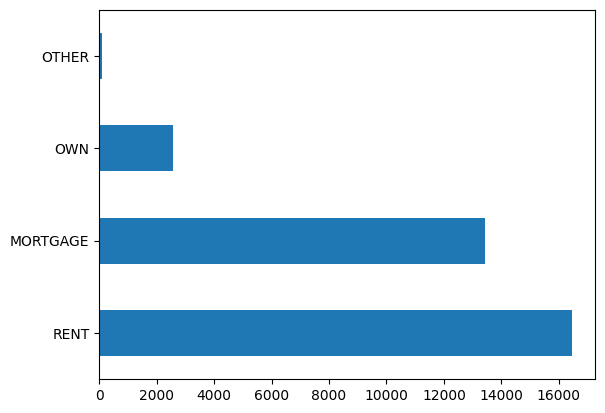

In [ ]:
print(df.Home.value_counts(normalize=True))
df.Home.value_counts().plot.barh();

<Axes: xlabel='Home', ylabel='count'>

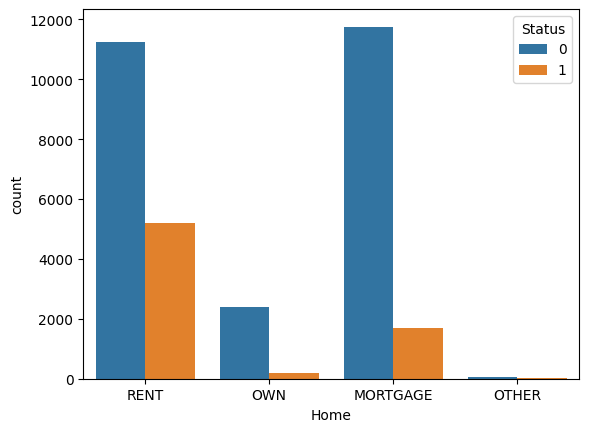

In [ ]:
sns.countplot(x='Home', hue='Status', data=df)

Home      Status
MORTGAGE  0         0.874293
          1         0.125707
OTHER     0         0.691589
          1         0.308411
OWN       0         0.925310
          1         0.074690
RENT      0         0.684300
          1         0.315700
Name: Status, dtype: float64


<Axes: xlabel='Home', ylabel='Status'>

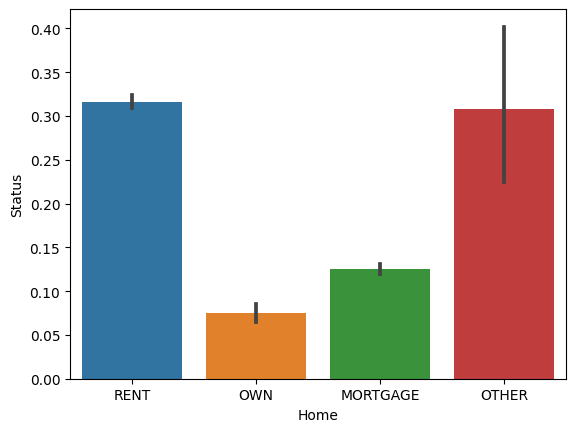

In [ ]:
print(df.groupby('Home')['Status'].value_counts(normalize=True))
sns.barplot(x='Home',y='Status', data=df)

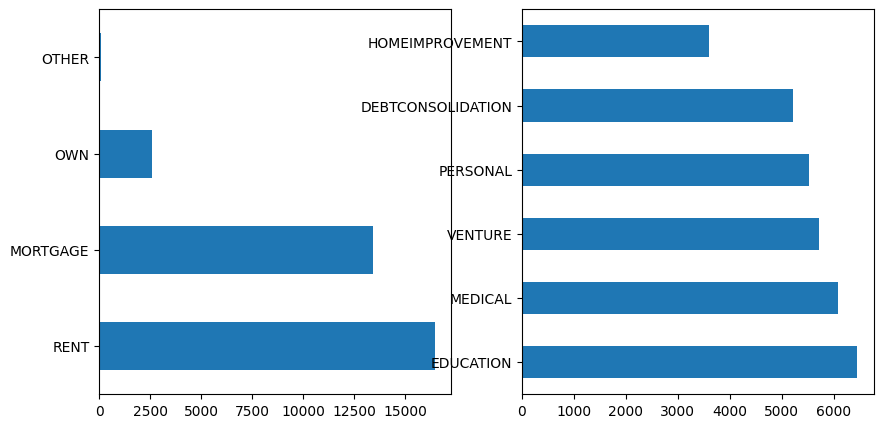

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
df["Home"].value_counts().plot.barh()
plt.subplot(122)
df["Intent"].value_counts().plot.barh()
plt.show()

In [ ]:
df.groupby('Home')['Intent'].value_counts(normalize=True)

Home      Intent           
MORTGAGE  EDUCATION            0.195403
          PERSONAL             0.174055
          DEBTCONSOLIDATION    0.171973
          VENTURE              0.166171
          MEDICAL              0.162898
          HOMEIMPROVEMENT      0.129500
OTHER     VENTURE              0.242991
          PERSONAL             0.168224
          DEBTCONSOLIDATION    0.158879
          EDUCATION            0.158879
          MEDICAL              0.158879
          HOMEIMPROVEMENT      0.112150
OWN       VENTURE              0.304180
          EDUCATION            0.204334
          PERSONAL             0.172601
          MEDICAL              0.167957
          HOMEIMPROVEMENT      0.123065
          DEBTCONSOLIDATION    0.027864
RENT      MEDICAL              0.208561
          EDUCATION            0.199501
          DEBTCONSOLIDATION    0.170923
          PERSONAL             0.165207
          VENTURE              0.162532
          HOMEIMPROVEMENT      0.093275
Name: Intent

<Axes: xlabel='Home', ylabel='Status'>

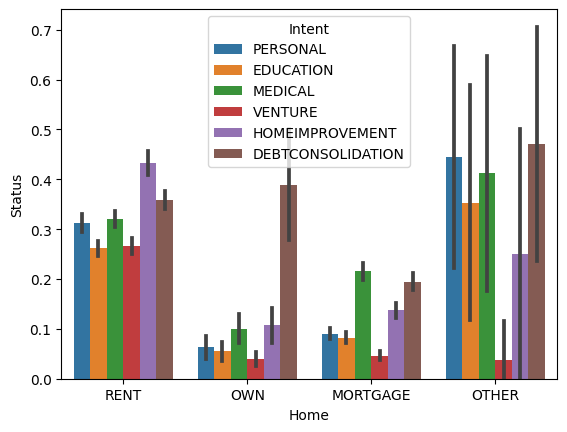

In [ ]:
sns.barplot(x = "Home", y= "Status", data = df, hue = "Intent")

---
Observe :    
* a
* b
* c

---

## Intent

EDUCATION            0.198060
MEDICAL              0.186336
VENTURE              0.175532
PERSONAL             0.169455
DEBTCONSOLIDATION    0.159971
HOMEIMPROVEMENT      0.110647
Name: Intent, dtype: float64


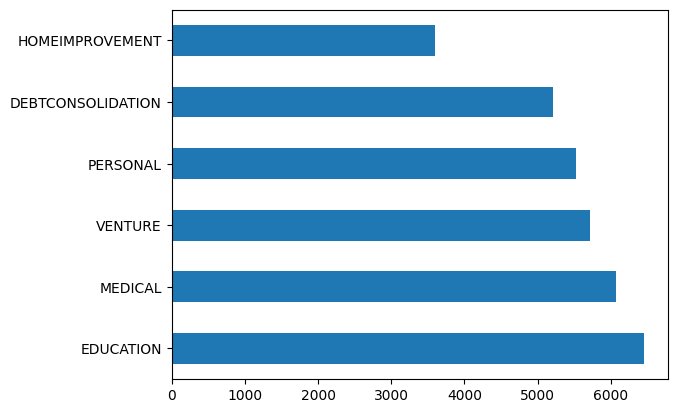

In [ ]:
print(df.Intent.value_counts(normalize=True))
df.Intent.value_counts().plot.barh();

In [ ]:
print(df.groupby("Intent")["Status"].value_counts(normalize = True))

Intent             Status
DEBTCONSOLIDATION  0         0.714121
                   1         0.285879
EDUCATION          0         0.827832
                   1         0.172168
HOMEIMPROVEMENT    0         0.738974
                   1         0.261026
MEDICAL            0         0.732993
                   1         0.267007
PERSONAL           0         0.801123
                   1         0.198877
VENTURE            0         0.851897
                   1         0.148103
Name: Status, dtype: float64


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'PERSONAL'),
  Text(1, 0, 'EDUCATION'),
  Text(2, 0, 'MEDICAL'),
  Text(3, 0, 'VENTURE'),
  Text(4, 0, 'HOMEIMPROVEMENT'),
  Text(5, 0, 'DEBTCONSOLIDATION')])

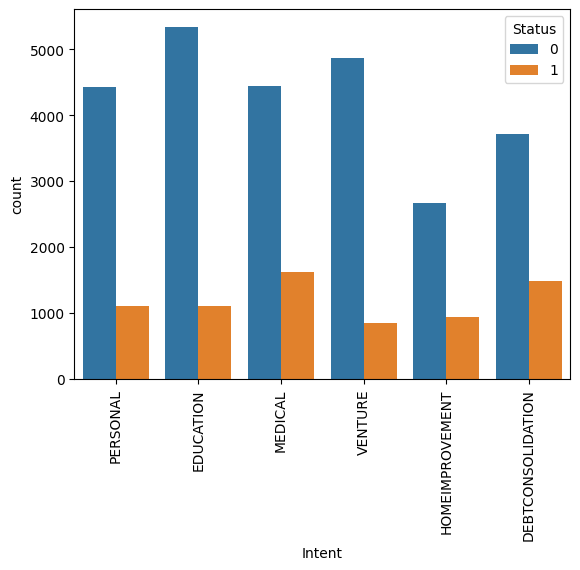

In [ ]:
sns.countplot(x='Intent', hue='Status', data=df)
plt.xticks(rotation=90)

## Default (Gagal Bayar)

N    0.82367
Y    0.17633
Name: Default, dtype: float64


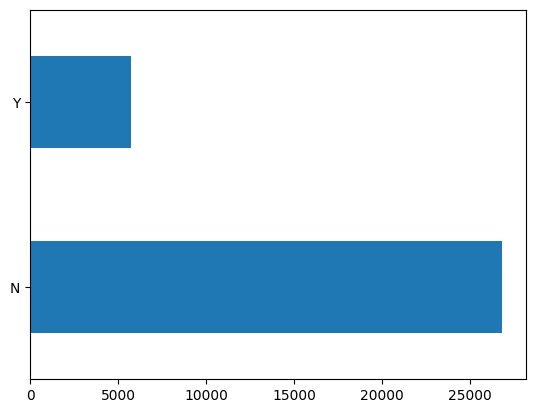

In [ ]:
print(df.Default.value_counts(normalize=True))
df.Default.value_counts().plot.barh();

In [ ]:
print(df.groupby("Default")["Status"].value_counts(normalize = True))

Default  Status
N        0         0.816068
         1         0.183932
Y        0         0.621932
         1         0.378068
Name: Status, dtype: float64


<Axes: xlabel='Default', ylabel='count'>

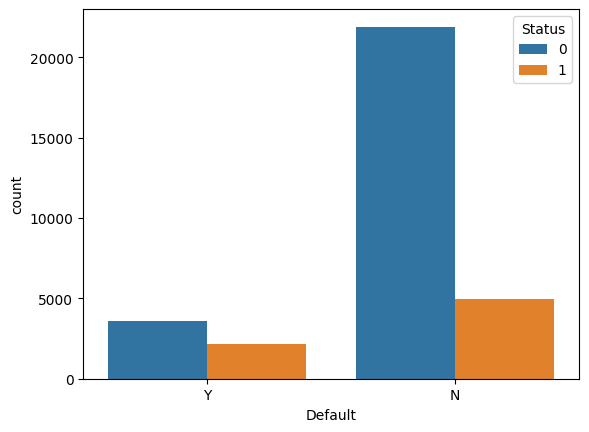

In [ ]:
sns.countplot(x='Default', hue='Status', data=df)


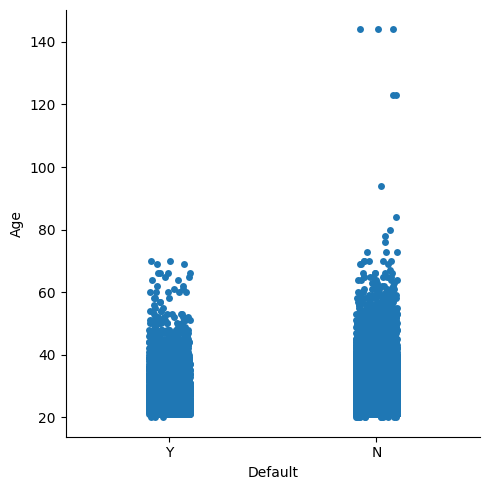

In [ ]:
sns.catplot(x = "Default",y= "Age", data = df)

In [ ]:
df.groupby("Default")[["Age", "Income", "Emp_length"]].aggregate(["min", "max"])

Age      Income          Emp_length       
        min  max    min      max        min    max
Default                                           
N        20  144   4080  6000000        0.0  123.0
Y        20   70   4000  2039784        0.0  123.0

In [ ]:
df.groupby('Default')['Intent'].value_counts(normalize=True)

Default  Intent           
N        EDUCATION            0.199396
         MEDICAL              0.186652
         VENTURE              0.176144
         PERSONAL             0.170033
         DEBTCONSOLIDATION    0.159375
         HOMEIMPROVEMENT      0.108399
Y        EDUCATION            0.191819
         MEDICAL              0.184856
         VENTURE              0.172672
         PERSONAL             0.166754
         DEBTCONSOLIDATION    0.162750
         HOMEIMPROVEMENT      0.121149
Name: Intent, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

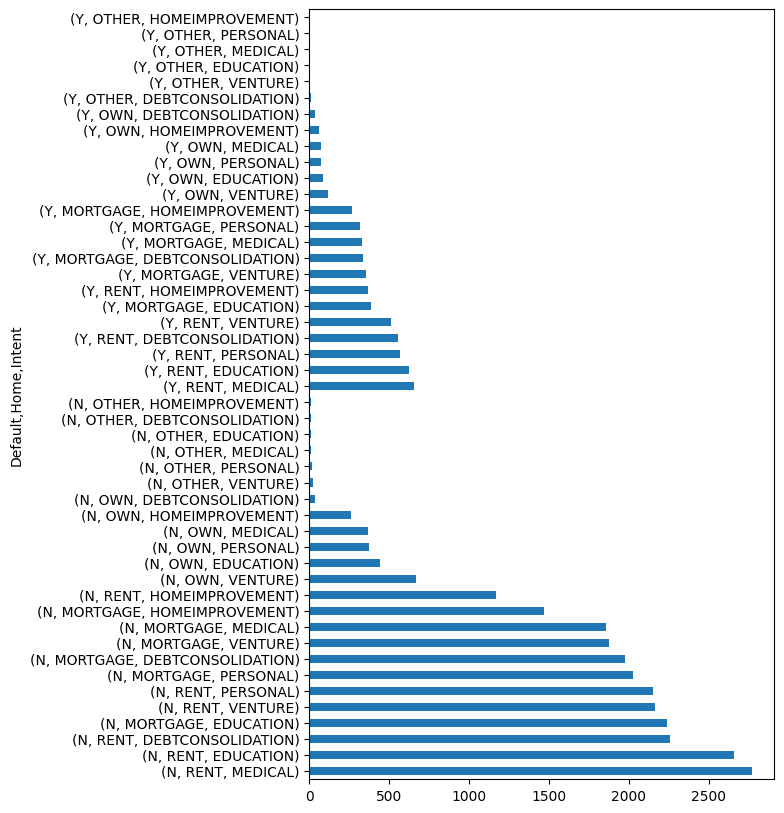

In [ ]:
plt.figure(figsize=(6, 10))
df.groupby("Default")[["Home", "Intent"]].value_counts().plot.barh()
plt.show

---
Observe :    
* a
* b
* c

---

## Age

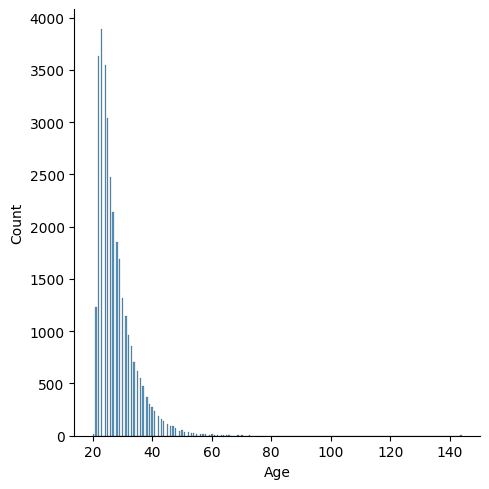

In [ ]:
sns.displot(df['Age'])

In [ ]:
df.columns

Index(['Id', 'Age', 'Income', 'Home', 'Emp_length', 'Intent', 'Amount', 'Rate',
       'Status', 'Percent_income', 'Default', 'Cred_length'],
      dtype='object')

<Axes: xlabel='Age', ylabel='Cred_length'>

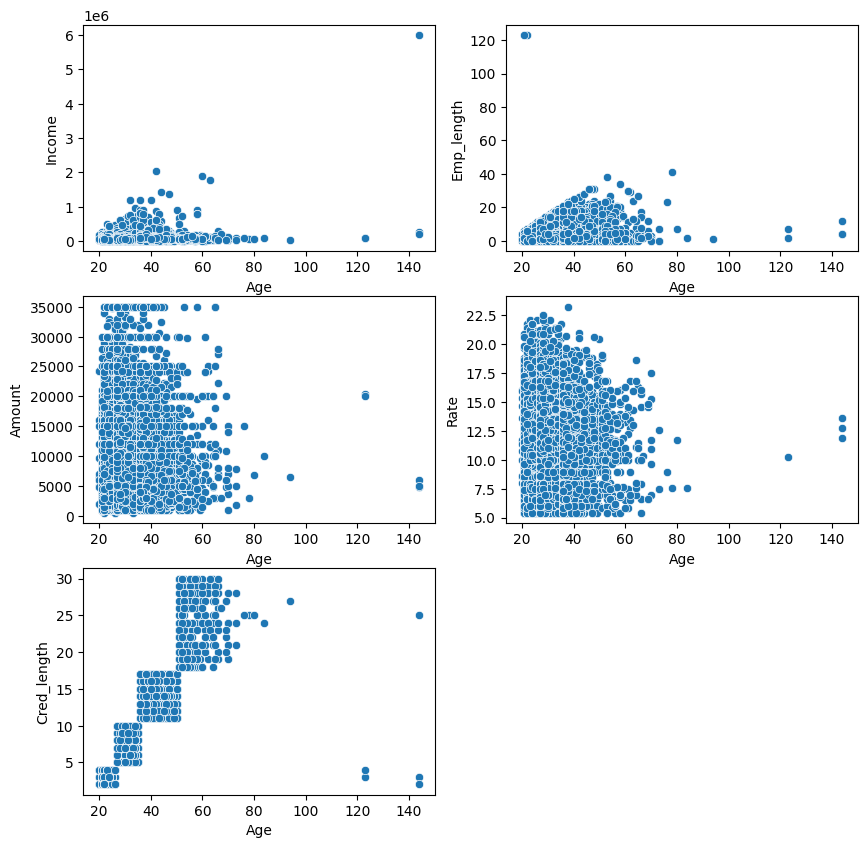

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(321)
sns.scatterplot(x = "Age", y = "Income", data = df)
plt.subplot(322)
sns.scatterplot(x = "Age", y = "Emp_length", data = df)
plt.subplot(323)
sns.scatterplot(x = "Age", y = "Amount", data = df)
plt.subplot(324)
sns.scatterplot(x = "Age", y = "Rate", data = df)
plt.subplot(325)
sns.scatterplot(x = "Age", y = "Cred_length", data = df)

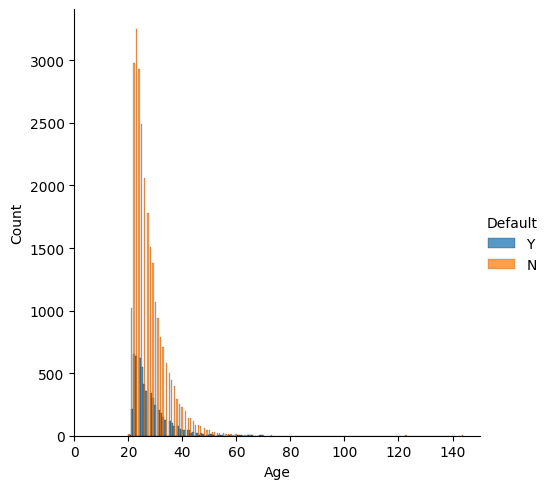

In [ ]:
(sns
.FacetGrid(df, hue = "Default", height=5,xlim=(0,150))
.map(sns.histplot, "Age")).add_legend()

In [ ]:
df.groupby("Default")["Age"].agg(["min", "max"])

,min,max
Default,,
N,20,144
Y,20,70


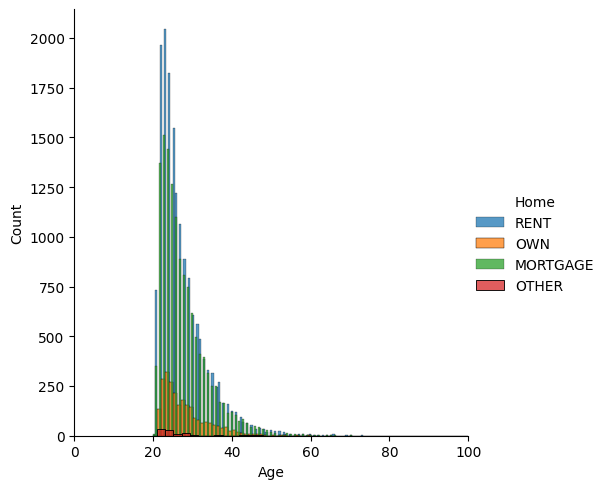

In [ ]:
(sns
.FacetGrid(df, hue = "Home", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

## Income

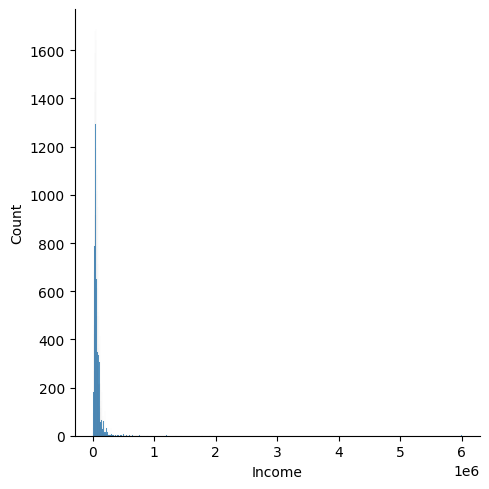

In [ ]:
sns.displot(df['Income'])

<Axes: >

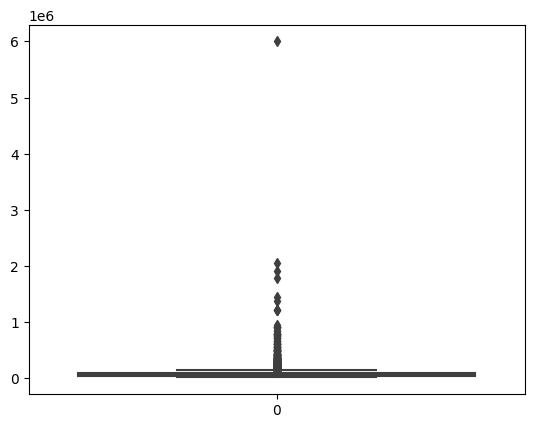

In [ ]:
sns.boxplot(df['Income'])

## Employeement Length

<Axes: >

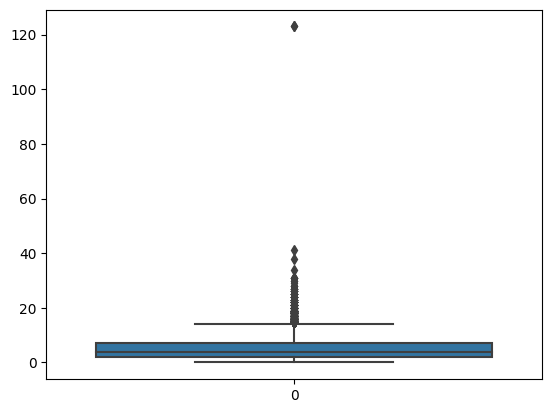

In [ ]:
sns.boxplot(df['Emp_length'])

## Credit Length

<Axes: >

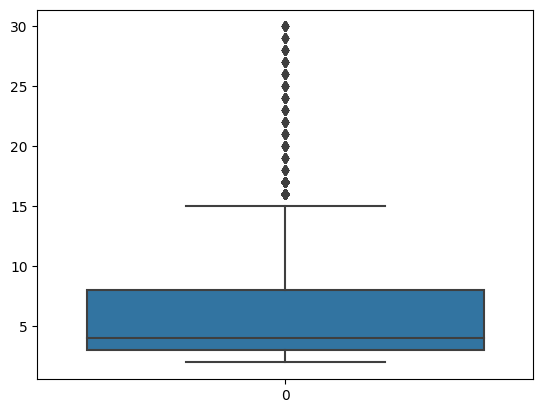

In [ ]:
sns.boxplot(df['Cred_length'])

---
Observe :    
* There is outliers in column Age, Income and Emp_length

---

# Feature Engineering and Missing Values

In [ ]:
df.isnull().sum()*100/len(df) #Check how much null values exist

Id                0.000000
Age               0.000000
Income            0.000000
Home              0.000000
Emp_length        2.747000
Intent            0.000000
Amount            0.000000
Rate              9.563856
Status            0.000000
Percent_income    0.000000
Default           0.000000
Cred_length       0.000000
dtype: float64

## Feature Encoding

In [ ]:
df_enc=df.copy(deep=True)

In [ ]:
# Encoding default columns to 0 and 1 values
df_enc['Default'] = df_enc['Default'].map({'N': 0, 'Y': 1})

In [ ]:
df_enc.Default.value_counts()

0    26836
1     5745
Name: Default, dtype: int64

In [ ]:
# Inisialisasi TargetEncoder
encoder = TargetEncoder()

# Mengkodekan kolom 'Home' dengan kolom 'Status' sebagai target
df_enc['Home'] = encoder.fit_transform(df['Home'], df['Status'])

# Mengkodekan kolom 'Intent' dengan kolom 'Status' sebagai target
df_enc['Intent'] = encoder.fit_transform(df['Intent'], df['Status'])

# Hasil enkoding
print(df_enc[['Home', 'Intent']])

           Home    Intent
0      0.315700  0.198877
1      0.074690  0.172168
2      0.125707  0.267007
3      0.315700  0.267007
4      0.315700  0.267007
...         ...       ...
32576  0.125707  0.198877
32577  0.125707  0.198877
32578  0.315700  0.261026
32579  0.125707  0.198877
32580  0.315700  0.267007

[32581 rows x 2 columns]


## Filling Missing Value

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df_enc), columns=df_enc.columns)

In [ ]:
#check
df_imputed.isnull().values.any()

False

## Outlier and Normalize

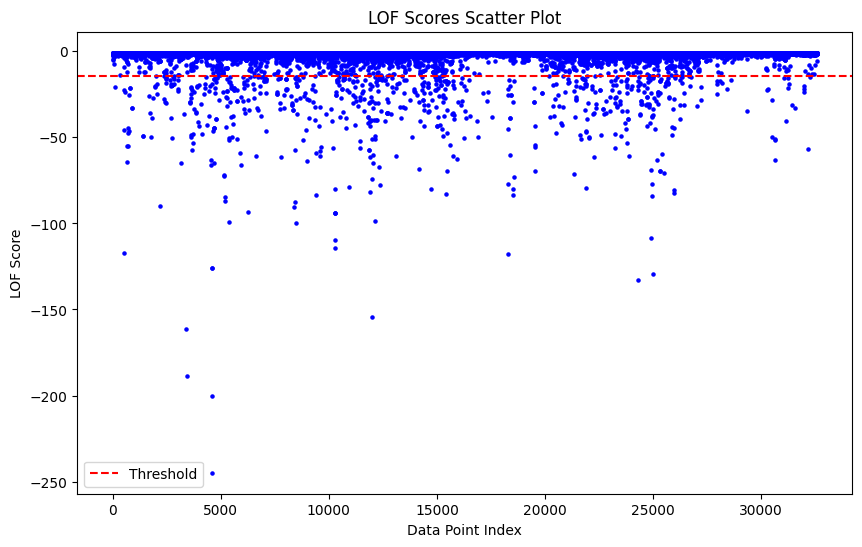

In [ ]:
# Buat model LOF
clf = LocalOutlierFactor(n_neighbors=5)

# Fit dan prediksi dengan LOF
clf.fit_predict(df_imputed)
clf_scores = clf.negative_outlier_factor_

# Visualisasi skor LOF dengan scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(clf_scores)), clf_scores, c='b', s=5)
plt.title('LOF Scores Scatter Plot')
plt.xlabel('Data Point Index')
plt.ylabel('LOF Score')
plt.axhline(y=-14.46, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [ ]:
thresold_value = np.sort(clf_scores)[700]

In [ ]:
np.sort(clf_scores)[700]

-14.465491952640818

In [ ]:
outlier_samples = df_imputed[clf_scores<thresold_value].to_records(index = False)

In [ ]:
outlier_samples[:]= df_imputed[clf_scores == thresold_value].to_records(index = False)

In [ ]:
df_imputed[clf_scores<thresold_value] = pd.DataFrame(outlier_samples, index = df_imputed[clf_scores<thresold_value].index)

In [ ]:
#check
df_imputed[clf_scores<thresold_value]

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
97,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
522,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
534,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
554,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
576,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31958,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
31968,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
31973,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0
32141,7005.0,26.0,39996.0,0.3157,2.0,0.285879,6200.0,13.79,0.0,0.16,0.0,2.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi Min-Max Scaler
scaler = MinMaxScaler()

# Menyekalakan dataframe df_imputed
df_imputed[df_imputed.columns] = scaler.fit_transform(df_imputed[df_imputed.columns])

In [ ]:
df_imputed

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0.000000,0.016129,0.009173,1.000000,1.000000,0.368527,1.000000,0.595506,1.0,0.710843,1.0,0.035714
1,0.000031,0.008065,0.000934,0.000000,0.040650,0.174669,0.014493,0.321348,0.0,0.120482,0.0,0.000000
2,0.000061,0.040323,0.000934,0.211677,0.008130,0.863026,0.144928,0.418539,1.0,0.686747,0.0,0.035714
3,0.000092,0.024194,0.010257,1.000000,0.032520,0.863026,1.000000,0.551124,1.0,0.638554,0.0,0.000000
4,0.000122,0.032258,0.008406,1.000000,0.065041,0.863026,1.000000,0.497191,1.0,0.662651,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,0.993777,0.298387,0.008172,0.211677,0.008130,0.368527,0.153623,0.434831,0.0,0.132530,0.0,1.000000
32577,0.993807,0.274194,0.019346,0.211677,0.032520,0.368527,0.496377,0.116292,0.0,0.180723,0.0,0.607143
32578,0.993838,0.362903,0.012008,1.000000,0.024390,0.819617,1.000000,0.312921,1.0,0.554217,0.0,0.928571
32579,0.993868,0.290323,0.024350,0.211677,0.040650,0.368527,0.420290,0.340449,0.0,0.120482,0.0,0.857143


In [ ]:
df_clean = df_imputed.drop(columns=["Id"])
df_clean

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0.016129,0.009173,1.000000,1.000000,0.368527,1.000000,0.595506,1.0,0.710843,1.0,0.035714
1,0.008065,0.000934,0.000000,0.040650,0.174669,0.014493,0.321348,0.0,0.120482,0.0,0.000000
2,0.040323,0.000934,0.211677,0.008130,0.863026,0.144928,0.418539,1.0,0.686747,0.0,0.035714
3,0.024194,0.010257,1.000000,0.032520,0.863026,1.000000,0.551124,1.0,0.638554,0.0,0.000000
4,0.032258,0.008406,1.000000,0.065041,0.863026,1.000000,0.497191,1.0,0.662651,1.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...
32576,0.298387,0.008172,0.211677,0.008130,0.368527,0.153623,0.434831,0.0,0.132530,0.0,1.000000
32577,0.274194,0.019346,0.211677,0.032520,0.368527,0.496377,0.116292,0.0,0.180723,0.0,0.607143
32578,0.362903,0.012008,1.000000,0.024390,0.819617,1.000000,0.312921,1.0,0.554217,0.0,0.928571
32579,0.290323,0.024350,0.211677,0.040650,0.368527,0.420290,0.340449,0.0,0.120482,0.0,0.857143


# Models

In [ ]:
X = df_clean.copy()
y = X.pop('Status')

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [ ]:
# Lakukan oversampling menggunakan SMOTE dengan parameter-parameter yang sudah diatur
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)
print(X_train.shape)
print(y_train.shape)

(35952, 10)
(35952,)
(22806, 10)
(22806,)


In [ ]:
print(y_train_resampled.value_counts())
print(y_train.value_counts())

1.0    17976
0.0    17976
Name: Status, dtype: int64
0.0    17976
1.0     4830
Name: Status, dtype: int64


---
---

## Logistic Regression

In [ ]:
#lr = LogisticRegression (class_weight='balanced',penalty='l2')
#lr_params = {
#    'C':[0.001,0.01,0.1,1],
#    'solver':['liblinear','lbfgs','newton-cg'],
#    'max_iter':[20,50,100,200]
#}

#lr_random = GridSearchCV(lr, param_grid=lr_params, cv=5, n_jobs=-1)
#lr_random.fit(X_train_resampled, y_train_resampled)

#best_params = lr_random.best_params_
#print("Parameter Terbaik:", best_params)

In [ ]:
lr_tuned = LogisticRegression(class_weight='balanced',penalty='l2', C=1, max_iter = 20, solver='newton-cg', random_state=42)
lr_tuned.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1, class_weight='balanced', max_iter=20, random_state=42,
                   solver='newton-cg')

In [ ]:
# Mengevaluasi model pada data test
y_pred = lr_tuned.predict(X_test)
y_pred_proba = lr_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.8341881646087427
Akurasi Model Terbaik pada Data Test: 0.7560102301790281
F1 Score Model Terbaik pada Data Test: 0.5695722793719544


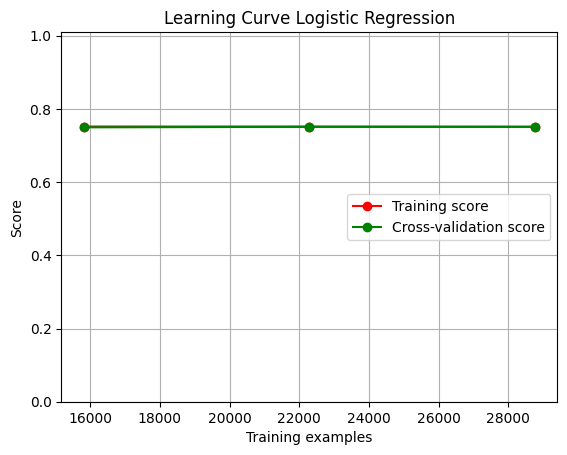

In [ ]:
# Fungsi untuk menghitung perbedaan akurasi antara pelatihan dan validasi
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Contoh penggunaan
#X, y = your_data  # Ganti dengan data Anda
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
estimator = lr_tuned  # Ganti dengan model Anda
title = "Learning Curve Logistic Regression"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

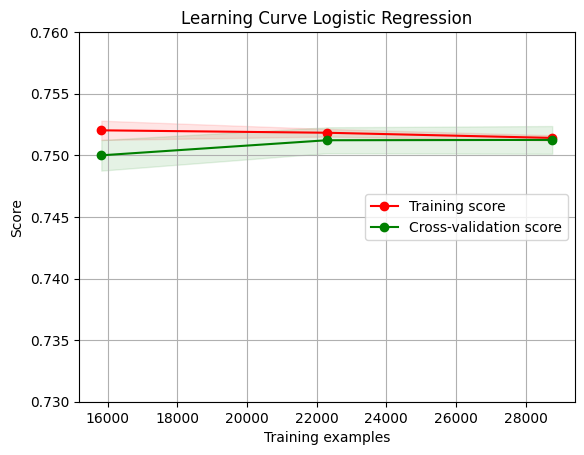

In [ ]:
estimator = lr_tuned  # Ganti dengan model Anda
title = "Learning Curve Logistic Regression"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.73, 0.76), cv=5)
plt.legend(loc='center right')
plt.show()

Text(0, 0.5, 'Feature Name')

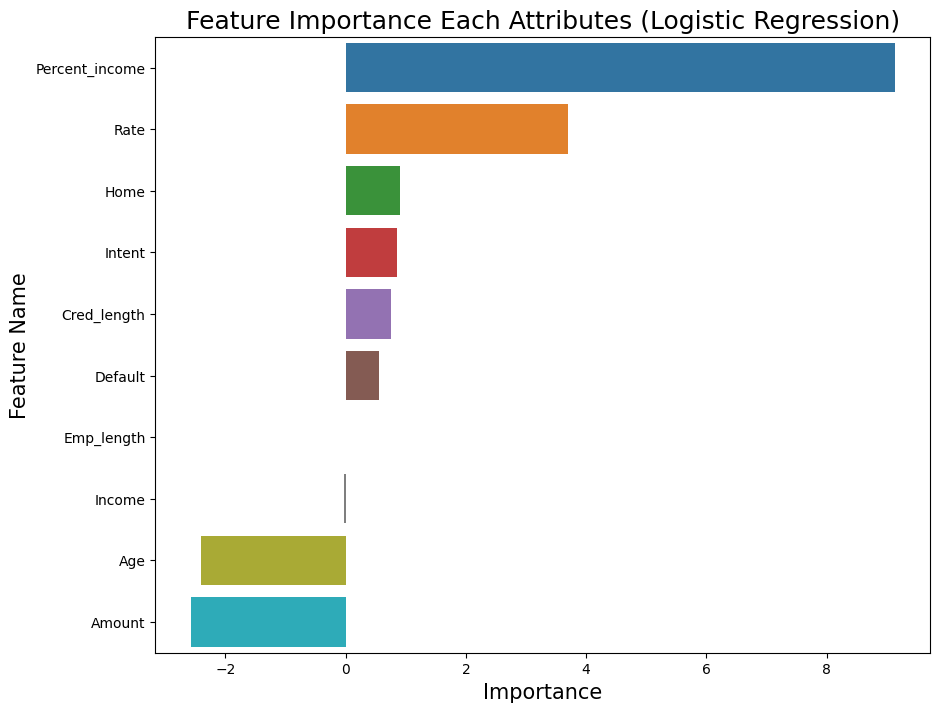

In [ ]:
imp_df = pd.DataFrame({
    'Feature Name' : X_train_resampled.columns,
    'Importance' : lr_tuned.coef_[0]
})
fi = imp_df.sort_values(by='Importance', ascending = False)
plt.figure(figsize = (10,8))
sns.barplot(data=fi, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Logistic Regression)', fontsize=18)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)

## KNN

In [ ]:
#knn = KNeighborsClassifier(weights='uniform',algorithm = 'auto',metric='manhattan')
#knn_params = {
#    'n_neighbors':[3,5,9,11],
#    'leaf_size': [1,3,11,15]
#}

#knn_random = GridSearchCV(knn, param_grid=knn_params, cv=5, n_jobs=-1)
#knn_random.fit(X_train_resampled, y_train_resampled)

#best_params = knn_random.best_params_
#print("Parameter Terbaik:", best_params)

In [ ]:
knn_tuned = KNeighborsClassifier(weights='uniform',algorithm = 'auto',metric='manhattan',leaf_size=1,n_neighbors=3)
knn_tuned.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(leaf_size=1, metric='manhattan', n_neighbors=3)

In [ ]:
# Mengevaluasi model pada data test
y_pred = knn_tuned.predict(X_test)
y_pred_proba = knn_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.8246549402603909
Akurasi Model Terbaik pada Data Test: 0.8160613810741688
F1 Score Model Terbaik pada Data Test: 0.6211546565528867


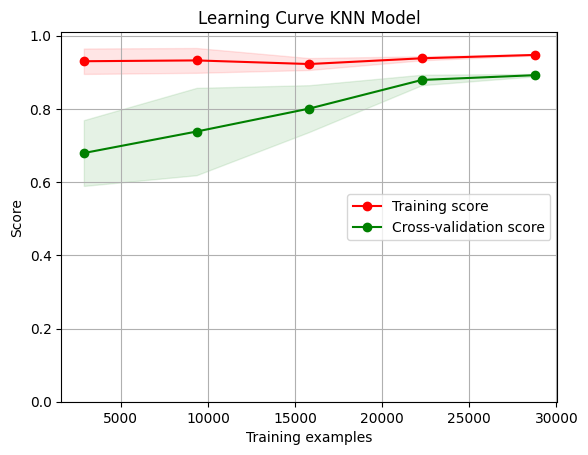

In [ ]:
# plot learning curve

estimator = knn_tuned  # Ganti dengan model Anda
title = "Learning Curve KNN Model"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

## Random Forest

In [ ]:
#rf = RandomForestClassifier(max_depth=30,min_samples_leaf=1,n_estimators=200)
#rf_params = {
#    'criterion':['gini','entropy'],
#    'max_features':['sqrt','auto','log2']

#}

#rf_random = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
#rf_random.fit(X_train_resampled, y_train_resampled)

#best_params = rf_random.best_params_
#print("Parameter Terbaik:", best_params)

max_depth= 30, min_samples_leaf= 1, n_estimators= 200, criterion='entropy', max_features='sqrt'

In [ ]:
rf_tuned = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, n_estimators= 200, criterion='entropy', max_features='sqrt',random_state=42)
rf_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=200,
                       random_state=42)

In [ ]:
# Mengevaluasi model pada data test
y_pred = rf_tuned.predict(X_test)
y_pred_proba = rf_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.9291406361058065
Akurasi Model Terbaik pada Data Test: 0.9154987212276214
F1 Score Model Terbaik pada Data Test: 0.7846715328467153


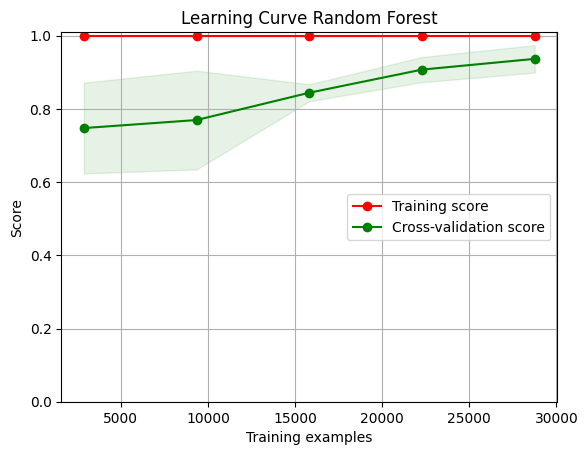

In [ ]:
# plot learning curve

estimator = rf_tuned  # Ganti dengan model Anda
title = "Learning Curve Random Forest"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

Text(0, 0.5, 'Feature Name')

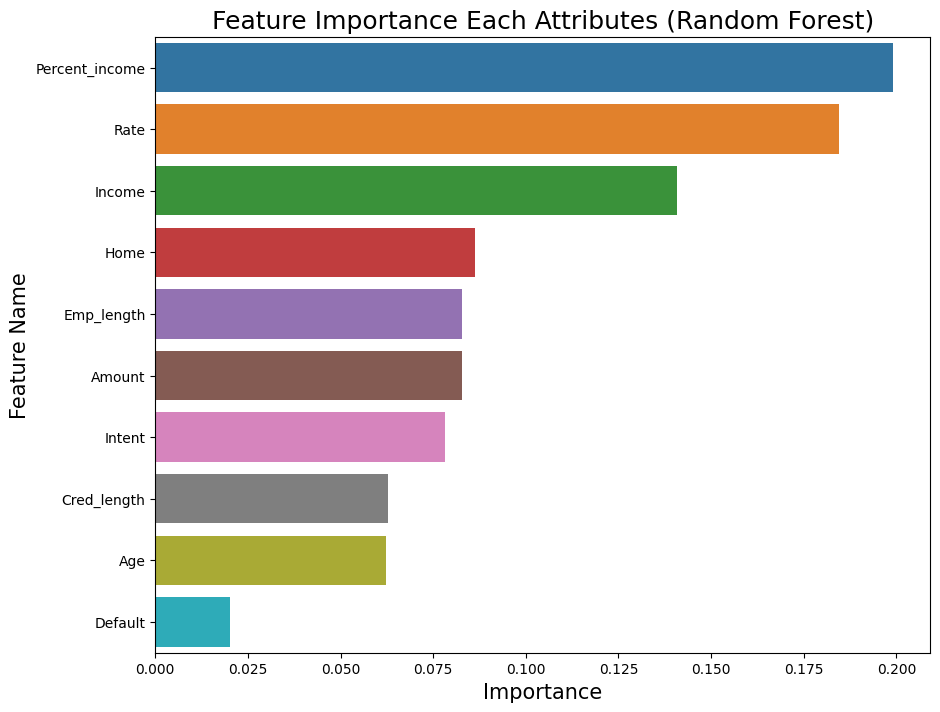

In [ ]:
imp_df = pd.DataFrame({
    'Feature Name' : X_train_resampled.columns,
    'Importance' : rf_tuned.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)
plt.figure(figsize = (10,8))
sns.barplot(data=fi, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)

## GBM

In [ ]:
#gbm = GradientBoostingClassifier(random_state = 42, learning_rate=0.1)
#gbm_params ={
#    'n_estimators' : [100,200,500],
#    'max_depth' : [3,5,10],

#}

#gbm_random = GridSearchCV(gbm,param_grid=gbm_params,cv=5, n_jobs=-1)
#gbm_random.fit(X_train_resampled, y_train_resampled)

#best_params = gbm_random.best_params_
#print("Parameter Terbaik:", best_params)

random_state = 42, learning_rate=0.01,max_depth=10,min_samples_split=9, n_estimators=200

random_state = 42, learning_rate=0.1,max_depth=10, n_estimators=500

In [ ]:
gbm_tuned = GradientBoostingClassifier(random_state = 42, learning_rate=0.1,max_depth=10, n_estimators=500)
gbm_tuned.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(max_depth=10, n_estimators=500, random_state=42)

In [ ]:
# Mengevaluasi model pada data test
y_pred = gbm_tuned.predict(X_test)
y_pred_proba = gbm_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.9450292087372223
Akurasi Model Terbaik pada Data Test: 0.9300255754475704
F1 Score Model Terbaik pada Data Test: 0.8181818181818182


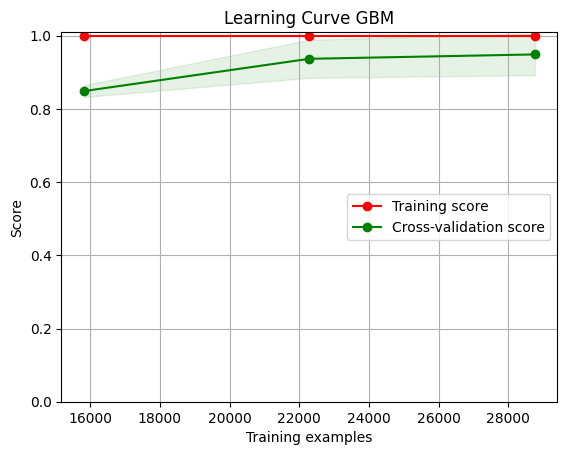

In [ ]:
# plot learning curve

estimator = gbm_tuned  # Ganti dengan model Anda
title = "Learning Curve GBM"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

Text(0, 0.5, 'Feature Name')

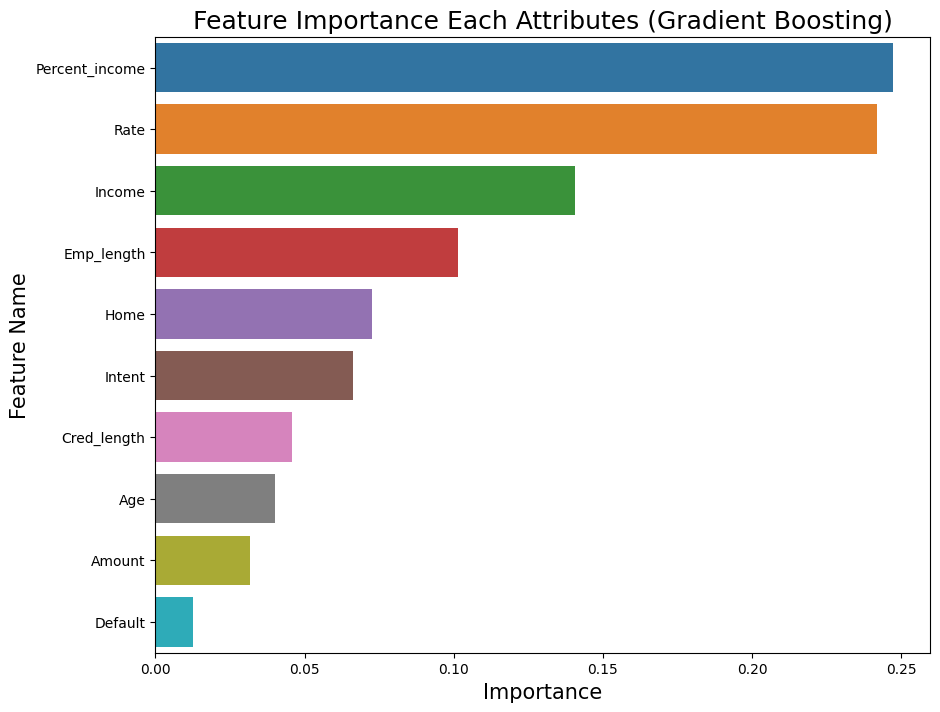

In [ ]:
imp_df = pd.DataFrame({
    'Feature Name' : X_train_resampled.columns,
    'Importance' : gbm_tuned.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)
plt.figure(figsize = (10,8))
sns.barplot(data=fi, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Gradient Boosting)', fontsize=18)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)

## LGBM

In [ ]:
#lgbm = LGBMClassifier(random_state = 42, learning_rate=0.1,boosting_type='gbdt',objective='binary')
#lgbm_params ={
#    'n_estimators' : [500,800,1000],
#    'max_depth' : [20,25,30],
#    'num_leaves' : [20,25,30]
#}

#lgbm_random = GridSearchCV(lgbm,param_grid=lgbm_params,cv=5, n_jobs=-1)
#lgbm_random.fit(X_train_resampled, y_train_resampled)

#best_params = lgbm_random.best_params_
#print("Parameter Terbaik:", best_params)

random_state = 42, learning_rate=0.1,boosting_type='gbdt',objective='binary',
                            max_depth=10,n_estimators=500,num_leaves=15 >> 94.09%

random_state = 42, learning_rate=0.1,boosting_type='gbdt',objective='binary',
                            max_depth=20,n_estimators=500,num_leaves=20 >> 94.2%

random_state = 42, learning_rate=0.1,boosting_type='gbdt',objective='binary',
                            max_depth=30,n_estimators=500,num_leaves=30 >> 94.3%

In [ ]:
lgbm_tuned = LGBMClassifier(random_state = 42, learning_rate=0.1,boosting_type='gbdt',objective='binary',
                            max_depth=30,n_estimators=500,num_leaves=30)
lgbm_tuned.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 17976, number of negative: 17976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2099
[LightGBM] [Info] Number of data points in the train set: 35952, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(max_depth=30, n_estimators=500, num_leaves=30,
               objective='binary', random_state=42)

In [ ]:
# Mengevaluasi model pada data test
y_pred = lgbm_tuned.predict(X_test)
y_pred_proba = lgbm_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.943317019550693
Akurasi Model Terbaik pada Data Test: 0.9298209718670076
F1 Score Model Terbaik pada Data Test: 0.8147948164146869


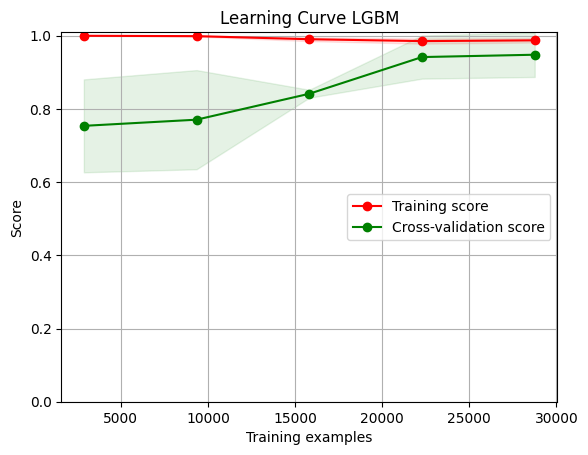

In [ ]:
# plot learning curve

estimator = lgbm_tuned  # Ganti dengan model Anda
title = "Learning Curve LGBM"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

Text(0, 0.5, 'Feature Name')

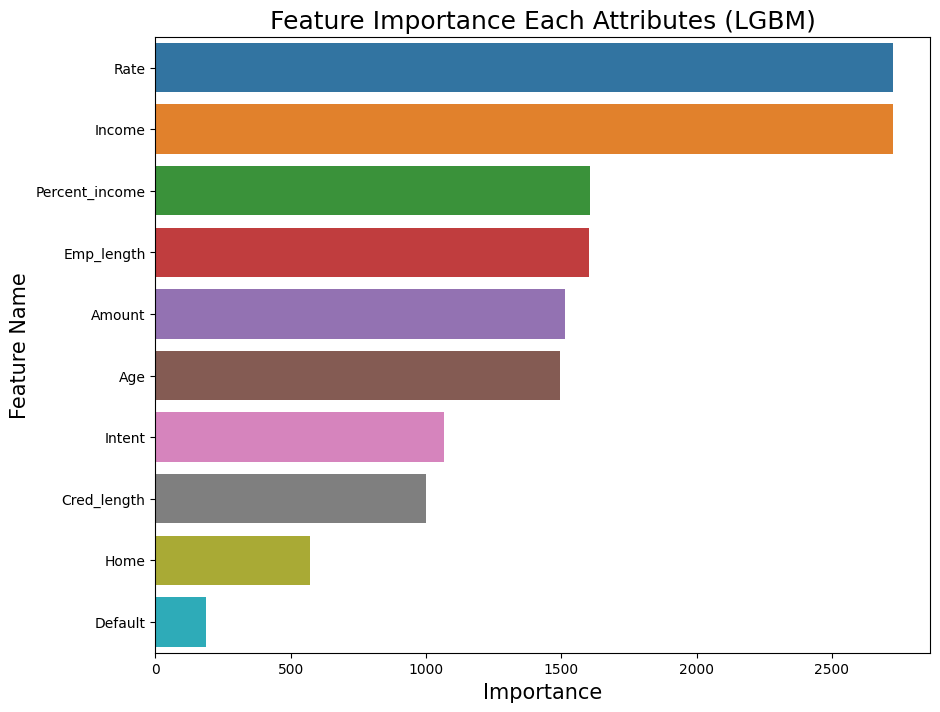

In [ ]:
imp_df = pd.DataFrame({
    'Feature Name' : X_train_resampled.columns,
    'Importance' : lgbm_tuned.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)
plt.figure(figsize = (10,8))
sns.barplot(data=fi, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (LGBM)', fontsize=18)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)

## XGB

In [ ]:
#xgb = XGBClassifier(random_state = 42, learning_rate=0.01,objective='binary:logistic',booster='gbtree')
#xgb_params ={
#    'n_estimators' : [200,500,800],
#    'max_depth' : [15,20,25],
#    'min_child_weight':[1,3,9,11]
#}

#xgb_random = GridSearchCV(xgb,param_grid=xgb_params,cv=5, n_jobs=-1)
#xgb_random.fit(X_train_resampled, y_train_resampled)

#best_params = xgb_random.best_params_
#print("Parameter Terbaik:", best_params)

random_state = 42, learning_rate=0.01,objective='binary:logistic',booster='gbtree', max_depth=15, n_estimators=500 >> 94.3% (training score turun)

random_state = 42, learning_rate=0.01,objective='binary:logistic',booster='gbtree',max_depth=15, n_estimators=800, min_child_weight=3 >> 94.33% (training score stabil)

In [ ]:
xgb_tuned = XGBClassifier(random_state = 42, learning_rate=0.01,objective='binary:logistic',booster='gbtree', max_depth=15, n_estimators=800, min_child_weight=3)
xgb_tuned.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
# Mengevaluasi model pada data test
y_pred = xgb_tuned.predict(X_test)
y_pred_proba = lgbm_tuned.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.943317019550693
Akurasi Model Terbaik pada Data Test: 0.9248081841432225
F1 Score Model Terbaik pada Data Test: 0.8023662274805055


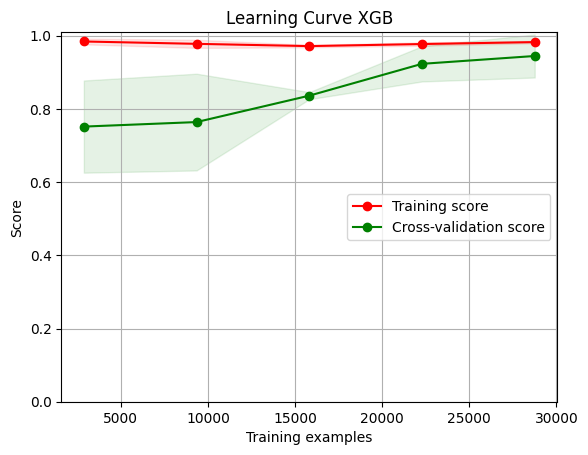

In [ ]:
# plot learning curve

estimator = xgb_tuned  # Ganti dengan model Anda
title = "Learning Curve XGB"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()

Text(0, 0.5, 'Feature Name')

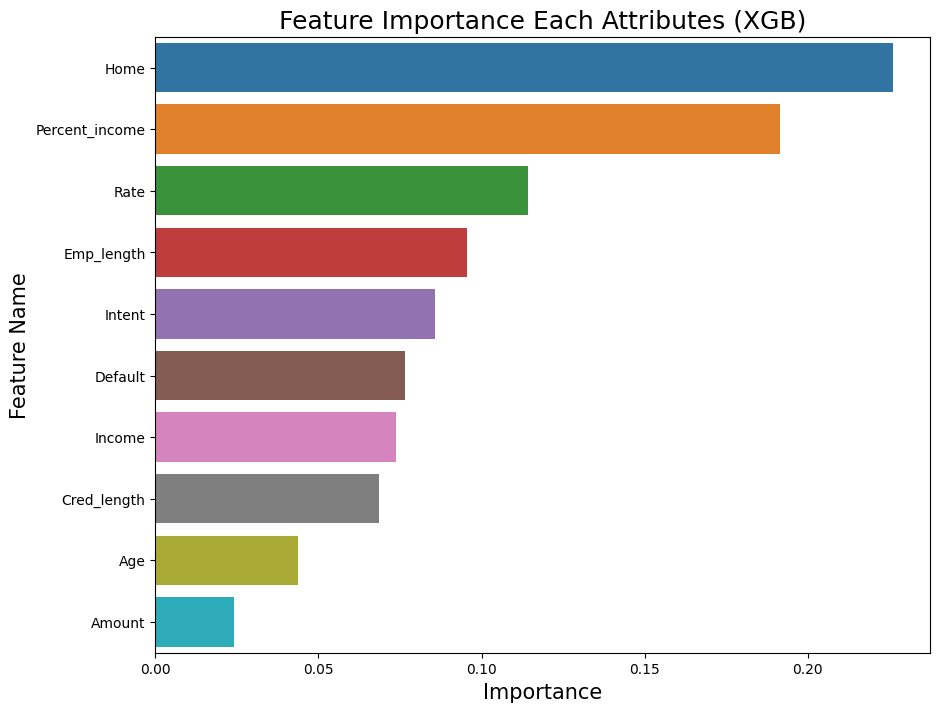

In [ ]:
imp_df = pd.DataFrame({
    'Feature Name' : X_train_resampled.columns,
    'Importance' : xgb_tuned.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)
plt.figure(figsize = (10,8))
sns.barplot(data=fi, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (XGB)', fontsize=18)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature Name', fontsize=15)

---

# Ensemble Model (Selection)

In [ ]:
models = ['Logistic Regression', 'KNN', 'Random Forest', 'GBM', 'LGBM','XGB']
roc_auc = [0.8341881646087427, 0.8246549402603909, 0.9291406361058065, 0.9450292087372223, 0.943317019550693, 0.943317019550693]
accuracy =[0.7560102301790281, 0.8160613810741688, 0.9154987212276214, 0.9300255754475704, 0.9298209718670076, 0.9248081841432225]
f1 =[0.5695722793719544,0.6211546565528867,  0.7846715328467153, 0.8181818181818182, 0.8147948164146869, 0.8023662274805055]
eval_df = pd.DataFrame({
    'Model' : models,
    'ROC AUC Score' : roc_auc,
    'Accuracy Score' : accuracy,
    'F1-Score' : f1
})
eval_df

,Model,ROC AUC Score,Accuracy Score,F1-Score
0,Logistic Regression,0.834188,0.756010,0.569572
1,KNN,0.824655,0.816061,0.621155
2,Random Forest,0.929141,0.915499,0.784672
3,GBM,0.945029,0.930026,0.818182
4,LGBM,0.943317,0.929821,0.814795
5,XGB,0.943317,0.924808,0.802366


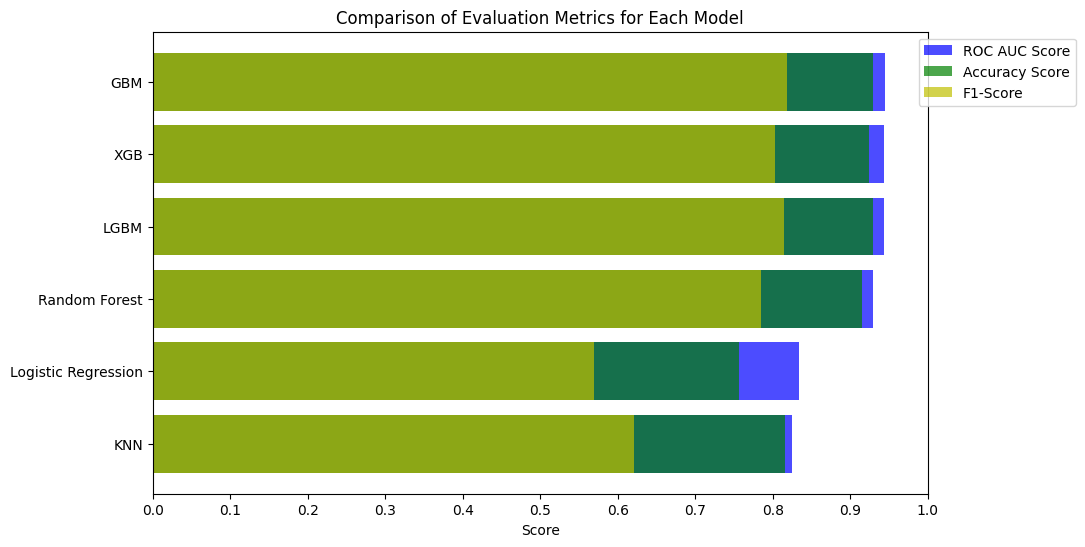

In [ ]:
# Membuat visualisasi
fig, ax = plt.subplots(figsize=(10, 6))

# Mengurutkan berdasarkan ROC AUC Score
eval_df = eval_df.sort_values(by='ROC AUC Score', ascending=True)

# Plot ROC AUC Score
ax.barh(eval_df['Model'], eval_df['ROC AUC Score'], color='b', alpha=0.7, label='ROC AUC Score')

# Plot Akurasi
ax.barh(eval_df['Model'], eval_df['Accuracy Score'], color='g', alpha=0.7, label='Accuracy Score')

# Plot F1-Score
ax.barh(eval_df['Model'], eval_df['F1-Score'], color='y', alpha=0.7, label='F1-Score')

# Menambahkan label sumbu dan judul
ax.set_xlabel('Score')
ax.set_title('Comparison of Evaluation Metrics for Each Model')
ax.set_xticks(np.arange(0, 1.1, 0.1))

# Menambahkan legenda
ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1))

# Menampilkan plot
plt.show()

In [ ]:
VotingC = VotingClassifier(
    estimators=[('gbm', gbm_tuned),('xgb',xgb_tuned),('lgbm',lgbm_tuned)],
    voting='soft', n_jobs=-1)
VotingC.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('gbm',
                              GradientBoostingClassifier(max_depth=10,
                                                         n_estimators=500,
                                                         random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster='gbtree',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=15,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=800, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(max_depth=30, n_estimators=500,
                                             num_leaves=30, objective='binary',
                                             random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# Mengevaluasi model pada data test
y_pred = VotingC.predict(X_test)
y_pred_proba = VotingC.predict_proba(X_test)[:, 1]  # Probabilitas kelas positif

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("ROC AUC Score Model Terbaik pada Data Test:", roc_auc)
print("Akurasi Model Terbaik pada Data Test:", accuracy)
print("F1 Score Model Terbaik pada Data Test:", f1)

ROC AUC Score Model Terbaik pada Data Test: 0.9447771457598745
Akurasi Model Terbaik pada Data Test: 0.9307416879795396
F1 Score Model Terbaik pada Data Test: 0.8176676541879881


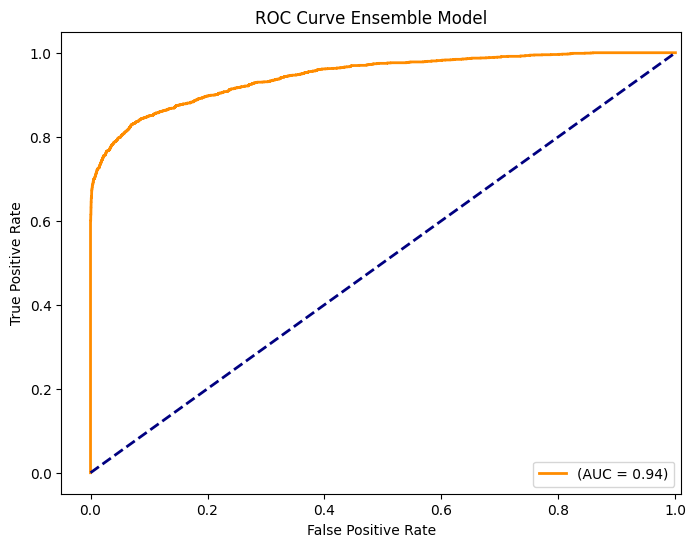

In [ ]:
# Hitung kurva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Gambarkan kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.01])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Ensemble Model')
plt.legend(loc='lower right')
plt.show()

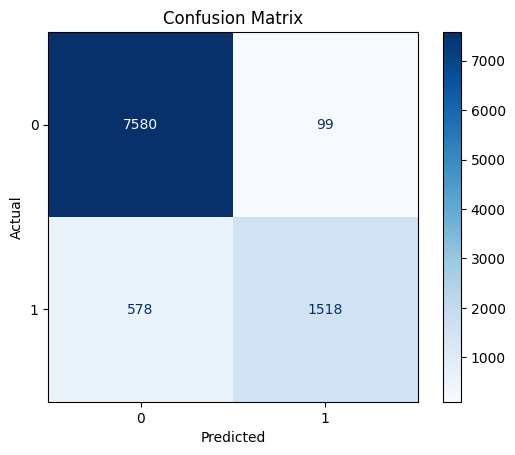

In [ ]:

# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix dengan ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


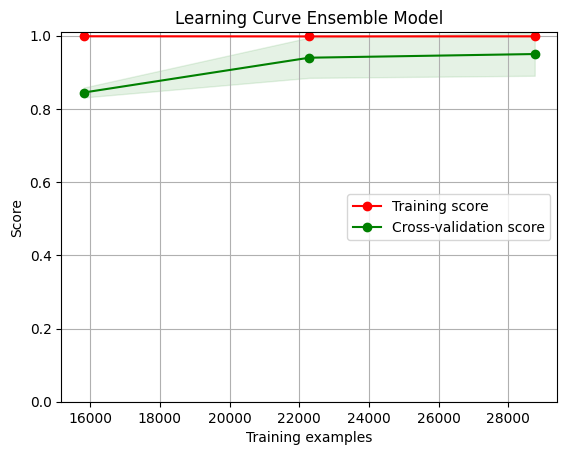

In [ ]:
# plot learning curve

estimator = VotingC  # Ganti dengan model Anda
title = "Learning Curve Ensemble Model"
plot_learning_curve(estimator, title, X_train_resampled, y_train_resampled, ylim=(0.0, 1.01), cv=5)
plt.legend(loc='center right')
plt.show()